# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [82]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from DrTorch.metrics import F1_Score_Multi_Labels


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting the device

In [83]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [84]:
if device != 'mps':
    !nvidia-smi


Mon Feb 19 18:55:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8               3W /  75W |    185MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [85]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [86]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df.head()


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [87]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


In [88]:
train_df, val_df, test_df = split_dataset(df)
print(f"Size of each dataset:\nTraining: {train_df.shape}\nValidation: {val_df.shape}\nTest: {test_df.shape}")

display(train_df.head())
display(val_df.head())
display(test_df.head())

Size of each dataset:
Training: (3200, 4)
Validation: (400, 4)
Test: (400, 4)


,speakers,emotions,utterances,triggers
0,"[Joey, Rachel, Joey]","[disgust, sadness, anger]","[One pregnant woman at a time, please! I just ...","[0, 0, 0]"
1,"[Monica, Rachel, Monica, Monica, Monica, Phoeb...","[joy, surprise, surprise, joy, neutral, sadnes...","[Now, this is last minute so I want to apologi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[Chandler, Ross, Chandler, Ross, Chandler, Ros...","[neutral, neutral, surprise, neutral, joy, neu...","[Hey., Chandler. I sensed it was you., What?!,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Phoebe, Rachel, Phoebe, Phoebe, Phoebe, Phoeb...","[neutral, surprise, surprise, neutral, surpris...",[Okay. Would you rather live in the shirt pock...,"[0, 0, 0, 0, 0, 0, 0, 0]"
4,"[Ross, Gunther, Joey, Ross, Joey, Rachel, Moni...","[joy, joy, neutral, neutral, joy, neutral, neu...","[Oh, hey, Gunther, check this out., Yeah, that...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


,speakers,emotions,utterances,triggers
3200,"[Phoebe, Phoebe Sr, Phoebe, Phoebe Sr, Phoebe,...","[sadness, surprise, neutral, surprise, neutral...","[I'm sorry., What are you doing here?!, I-I, c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3201,"[Ross, Phoebe, Monica, Phoebe, Monica, Phoebe,...","[neutral, neutral, neutral, neutral, neutral, ...","[That's the day you're gonna die? Seedarnit, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3202,"[Joey, Chandler, Joey, Chandler, Joey, Chandle...","[neutral, neutral, anger, joy, joy, sadness, s...","[I know it doesn't make much sense, Much, Look...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3203,"[Ross, Aunt Lillian, Monica, Mrs. Geller, Moni...","[sadness, sadness, sadness, anger, surprise, s...","[So, uh, how's she doing?, The doctor says it'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3204,"[Monica, Chandler, Chandler, Monica, Chandler,...","[surprise, neutral, neutral, surprise, neutral...","[Oh yeah? When?, I'll tell you what., When we'...","[0, 0, 0, 0, 0, 0]"


,speakers,emotions,utterances,triggers
3600,"[Russell, Ross, Russell, Ross, Russell, Russel...","[neutral, neutral, neutral, neutral, neutral, ...","[You got married again., Yes., So that's your ...","[0, 0, 0, 0, 0, 0, 0, 0]"
3601,"[Monica, The Food Critic, Monica, The Food Cri...","[neutral, surprise, neutral, joy, anger, joy]","[Hi! Umm, I'm Monica Geller, I'm the chef at A...","[0, 0, 0, 0, 0, 0]"
3602,"[All, Ross, Phoebe, Rachel, Phoebe, Rachel, Ph...","[neutral, neutral, joy, surprise, neutral, dis...","[Hey., How's the maniac?, Oh, well he's yummy....","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3603,"[Chandler, Joey, Chandler]","[fear, neutral, surprise]","[What're we gonna do? What're we gonna do?, Uh...","[0, 0, 0]"
3604,"[Joey, Chandler, Joey, Joey, Chandler, Joey, J...","[anger, neutral, anger, anger, neutral, neutra...","[You're driving me crazy with that!, Okay, I'l...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


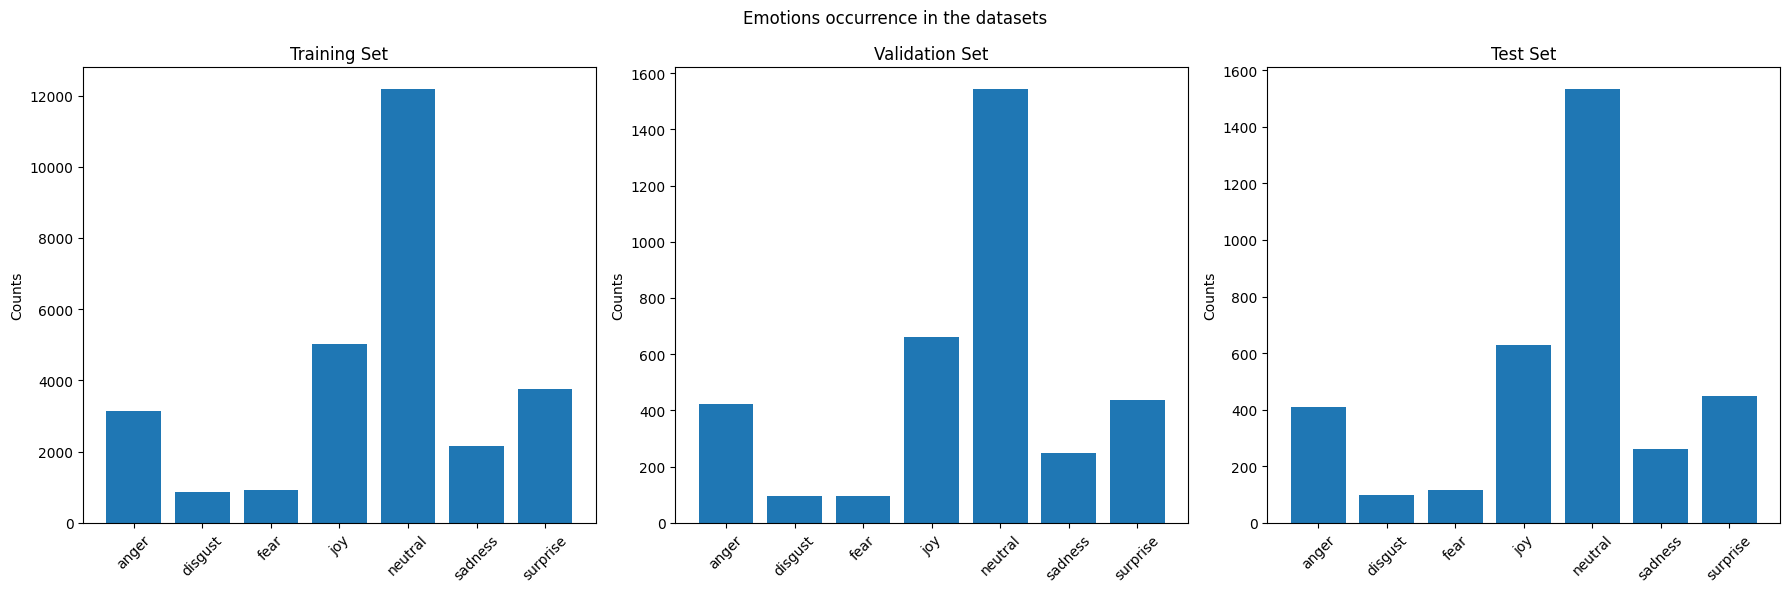

In [94]:
plot_emotion_distribution(train_df, val_df, test_df)

## Random Classifier

In [ ]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
print(pred_emotions[0], pred_triggers[0])


## Majority Classifier

In [ ]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
print(pred_emotions[0], pred_triggers[0])


## Bert Models

In [ ]:
# todo Bert Models
# todo capire come fare l'encoding di frasi e SOPRATTUTTO emotions

# Mauro fa schifo ihihih